In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import random
from scipy import io

# Gaussian Classifiers for Digits and Spam

## preparation
load data and define functions for later use

In [11]:
data_mnist = io.loadmat("data/mnist_data.mat")

np.random.seed(2020)

def partition(data, val_set_size):
    training_data = data["training_data"]
    training_labels = data["training_labels"]
    # shuffle datasets before partition
    shuffle_index = random.sample(range(len(training_data)), 
                                        len(training_data))
    training_data = training_data[shuffle_index]
    training_labels = training_labels[shuffle_index]
    #partition data into training and validation set
    val_ind = random.sample(range(len(training_data)), val_set_size)
    val_x = training_data[val_ind]
    val_y = training_labels[val_ind]
    train_x = np.delete(training_data, val_ind, axis = 0)
    train_y = np.delete(training_labels, val_ind, axis = 0)
    return([train_x, train_y, val_x, val_y])

def get_norm(x):
    norm = np.sqrt(np.sum(x**2, axis = 1))
    x_norm = x.copy()
    for i in range(len(x_norm)):
        x_norm[i,:] = x_norm[i,:] / norm[i]
    return(x_norm)

def get_mean(x, y, class_num):
    mean_by_class = pd.DataFrame()
    for i in range(class_num):
        mean_by_class[i] = np.mean(x[(y == i).ravel(),:],
                     axis = 0).tolist()
    return(mean_by_class)

def get_cov(x, y, class_num):
    cov_by_class = [None] * class_num
    for i in range(class_num):
        data_class_i = x[(y == i).ravel(),:].transpose()
        cov_by_class[i] = np.cov(data_class_i)
    return(cov_by_class)

def get_prior(y, class_num):
    prior_by_class = [None] * class_num
    n = len(y)
    for i in range(class_num):
        prior_by_class[i] = sum(y == i) / n
    return(prior_by_class)

def get_error_rate(y_pred, y_true, class_num):
    error_by_class = []
    for i in range(class_num):
        ind = y_true.ravel() == i
        y_true_i = y_true[ind]
        y_pred_i = y_pred[ind]
        error_by_class.append(np.sum(y_pred_i != y_true_i.ravel()) / len(y_true_i))
    return(error_by_class)

[train_x_full, train_y_full, val_x, val_y] = partition(data_mnist, 10000)
train_x_full = train_x_full.astype(float)
val_x = val_x.astype(float)

## 8.1
The gaussian distribution is fit to each digit class.  An example of the mean and covariance matrix is demonstrated

In [5]:
# normalize the feature
train_x_norm = get_norm(train_x_full)
# fit the gaussian distribution
mean_by_digit = get_mean(train_x_norm, train_y_full, 10)
cov_by_digit = get_cov(train_x_norm, train_y_full, 10)

print(mean_by_digit[0])
print(cov_by_digit[0])
print(cov_by_digit[0].shape)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
779    0.0
780    0.0
781    0.0
782    0.0
783    0.0
Name: 0, Length: 784, dtype: float64
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(784, 784)


## 8.2
The terms on the diagonal and within the narrow band close to it are greater than 0 and have relatively larger magnitude whereas off-diagonal terms are close to 0. We can thus conclude that pixels having close positions have large correlation whereas pixels far apart are almost uncorrelated.

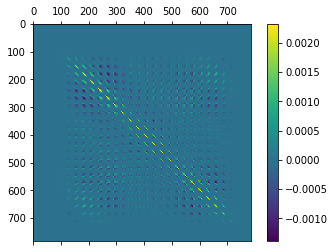

In [10]:
fig, ax = plt.subplots()
plot1 = ax.matshow(cov_by_digit[5])
fig.colorbar(plot1)

## 8.3

### (a) LDA

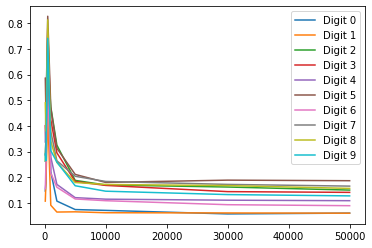

In [19]:
train_set_size = [100,200,500,1000,2000,5000,10000,30000,50000]
error_digit_size_lda = pd.DataFrame()
for j in train_set_size:
    # because the data was randomly shuffled before, we can now directly take
    # the first j rows as training set each time
    train_x = train_x_full[range(j)]
    train_y = train_y_full[range(j)]
    # normalize the features
    train_x_norm = get_norm(train_x)
    val_x_norm = get_norm(val_x)
    
    # fit gaussian distribution for each class using training set
    mean_by_digit = get_mean(train_x_norm, train_y, 10)
    cov_by_digit = get_cov(train_x_norm, train_y, 10)
    prior_by_digit = get_prior(train_y, 10)
    
    # average the 10 covariance matrix and assume the result to be the same
    # covariance matrix for all classes
    sigma = 0
    for i in range(10):
        sigma = sigma + cov_by_digit[i]
    sigma = sigma / 10
    
    # performance on validation set 
    post_prob_by_digit = pd.DataFrame()
    for i in range(10):
        x_minus_mu = np.apply_along_axis(
                lambda x: x - mean_by_digit[i], 0, val_x_norm.T)
        # add sufficiently small perturbation to the diagonal to make covariance matrix invertible
        # use the same sigma for all digit classes
        invertible_sigma = sigma + np.diag(np.repeat(1e-16, len(sigma)))
        # solve linear equation system to avoid compute sigma inverse
        z = np.linalg.solve(invertible_sigma, x_minus_mu)
        # log of conditional probability, constant terms omitted
        pdf = -x_minus_mu.T * z.T
        log_cond_prob = np.sum(pdf, axis = 1)
        # log of posterior probability
        log_post_prob = log_cond_prob + np.log(prior_by_digit[i])
        post_prob_by_digit[i] = log_post_prob.tolist() 
    
    y_pred_lda = post_prob_by_digit.idxmax(axis = 1)
    error_by_digit = get_error_rate(y_pred_lda, val_y, 10)
    error_digit_size_lda[j] = error_by_digit

fig, ax = plt.subplots()
for i in range(10):
    ax.plot(train_set_size, error_digit_size_lda.iloc[i,:], label = 'Digit ' + str(i))
ax.legend()

In [33]:
error_digit_size_lda[50000]

0    0.060510
1    0.060177
2    0.150099
3    0.141199
4    0.108803
5    0.186592
6    0.089320
7    0.165550
8    0.156692
9    0.127530
Name: 50000, dtype: float64

As shown above, digit 1 is the easiest to classify (when using the training set of size 50000)

### (b) QDA

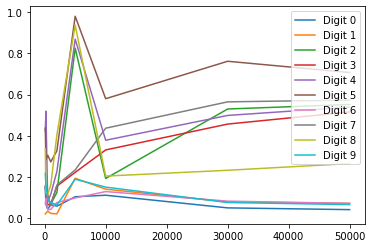

In [20]:
train_set_size = [100,200,500,1000,2000,5000,10000,30000,50000]
error_digit_size_qda = pd.DataFrame()
for j in train_set_size:
    # because the data was randomly shuffled before, we can now directly take
    # the first j rows as training set each time
    train_x = train_x_full[range(j)]
    train_y = train_y_full[range(j)]
    # normalize the features
    train_x_norm = get_norm(train_x)
    val_x_norm = get_norm(val_x)
    
    # fit gaussian distribution for each class using training set
    mean_by_digit = get_mean(train_x_norm, train_y, 10)
    cov_by_digit = get_cov(train_x_norm, train_y, 10)
    prior_by_digit = get_prior(train_y, 10)
    
    # performance on validation set 
    post_prob_by_digit = pd.DataFrame()
    for i in range(10):
        x_minus_mu = np.apply_along_axis(
                lambda x: x - mean_by_digit[i], 0, val_x_norm.T)
        # add sufficiently small perturbation to the diagonal to make covariance matrix invertible
        # use different sigma for each class
        invertible_sigma = cov_by_digit[i] + np.diag(np.repeat(1e-16, len(cov_by_digit[i])))
        # solve linear equation system to avoid compute sigma inverse
        z = np.linalg.solve(invertible_sigma, x_minus_mu)
        # log of conditional probability, constant terms omitted
        pdf = x_minus_mu.T * z.T
        (sign, logdet) = np.linalg.slogdet(invertible_sigma)
        log_cond_prob = - 0.5 * sign * logdet - np.sum(pdf, axis = 1) / 2
        # log of posterior probability
        log_post_prob = log_cond_prob + np.log(prior_by_digit[i])
        post_prob_by_digit[i] = log_post_prob.tolist() 
    
    y_pred_qda = post_prob_by_digit.idxmax(axis = 1)
    error_by_digit = get_error_rate(y_pred_qda, val_y, 10)
    error_digit_size_qda[j] = error_by_digit

fig, ax = plt.subplots()
for i in range(10):
    ax.plot(train_set_size, error_digit_size.iloc[i,:], label = 'Digit ' + str(i))
ax.legend(loc = 'upper right')

In [31]:
error_digit_size_qda[50000]

0    0.040340
1    0.070796
2    0.551690
3    0.515474
4    0.539070
5    0.707263
6    0.070874
7    0.573206
8    0.264418
9    0.064777
Name: 50000, dtype: float64

As shown above, digit 0 is the easiest to classify (when using the training set of size 50000)

### (c)
QDA is better, because it allows a different covariance matrix for each digit class, which is closer to the reality about the data.

### (d) Kaggle MNIST
Name: Gary Lin

Score (Accuracy Rate): 0.90400

#### Step1: hyperparameter tuning, find the best perturbation constant $\delta$ to fix singularity

In [62]:
train_x = train_x_full[range(10000)]
train_y = train_y_full[range(10000)]
train_x_norm = get_norm(train_x)
val_x_norm = get_norm(val_x)
mean_by_digit = get_mean(train_x_norm, train_y, 10)
cov_by_digit = get_cov(train_x_norm, train_y, 10)
prior_by_digit = get_prior(train_y, 10)

# set up the hyperparameter vector delta
delta_vec = []
delta0 = 1e-20
for i in range(20):
    delta_vec.append(delta0)
    delta0 *= 10

accuracy_by_delta_qda = [None] * len(delta_vec)
# find the best delta
for k in range(len(delta_vec)):  
    post_prob_by_digit = pd.DataFrame()
    for i in range(10):
        x_minus_mu = np.apply_along_axis(
                lambda x: x - mean_by_digit[i], 0, val_x_norm.T)
        # use different delta each time
        invertible_sigma = cov_by_digit[i] + np.diag(np.repeat(delta_vec[k], len(cov_by_digit[i])))
        z = np.linalg.solve(invertible_sigma, x_minus_mu)
        pdf = x_minus_mu.T * z.T
        (sign, logdet) = np.linalg.slogdet(invertible_sigma)
        log_cond_prob = - 0.5 * sign * logdet - np.sum(pdf, axis = 1) / 2
        log_post_prob = log_cond_prob + np.log(prior_by_digit[i])
        post_prob_by_digit[i] = log_post_prob.tolist() 
    
    y_pred_lda = post_prob_by_digit.idxmax(axis = 1)
    accuracy_by_delta_qda[k] = sum(y_pred_lda == val_y.ravel()) / len(val_y)
delta_optimal = delta_vec[accuracy_by_delta_qda.index(max(accuracy_by_delta_qda))]

In [66]:
delta_optimal

0.0010000000000000005

#### Step2: Retrain using the full training set

In [64]:
train_x_norm = get_norm(train_x_full)
val_x_norm = get_norm(val_x)
mean_by_digit = get_mean(train_x_norm, train_y_full, 10)
cov_by_digit = get_cov(train_x_norm, train_y_full, 10)
prior_by_digit = get_prior(train_y_full, 10)

#### Step3: Prediction using QDA

In [65]:
test_x = data_mnist["test_data"]
test_x_norm = get_norm(test_x)

post_prob_by_digit = pd.DataFrame()
for i in range(10):
    x_minus_mu = np.apply_along_axis(lambda x: x - mean_by_digit[i], 0, test_x_norm.T)
    invertible_sigma = cov_by_digit[i] + np.diag(
            np.repeat(delta_optimal, len(cov_by_digit[i]))) # delta_optimal = 0.001
    z = np.linalg.solve(invertible_sigma, x_minus_mu)
    pdf = x_minus_mu.T * z.T
    (sign, logdet) = np.linalg.slogdet(invertible_sigma)
    log_cond_prob = - 0.5 * sign * logdet - np.sum(pdf, axis = 1) / 2
    log_post_prob = log_cond_prob + np.log(prior_by_digit[i])
    post_prob_by_digit[i] = log_post_prob.tolist() 
y_test_pred = post_prob_by_digit.idxmax(axis = 1)

def results_to_csv(y_test, filename):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv(filename, index_label='Id')

results_to_csv(y_test_pred, 'submission_mnist_e3_qda.csv')

## 8.4 Kaggle SPAM
Name: Gary Lin

Score (Accuracy Rate): 0.82602

In [70]:
# Use LDA for Prediction
data_spam = io.loadmat("data/spam_data.mat")
train_x= data_spam["training_data"]
train_y = data_spam["training_labels"]
train_x = train_x.astype(float)

mean_by_class = get_mean(train_x, train_y, 2) # 2 indicates binary label
cov_by_class = get_cov(train_x, train_y, 2)
prior_by_class = get_prior(train_y, 2)
sigma = (cov_by_class[0] + cov_by_class[1]) / 2

test_x = data_spam["test_data"]

post_prob_by_class = pd.DataFrame()
for i in range(2):
    x_minus_mu = np.apply_along_axis(lambda x: x - mean_by_class[i], 0, test_x.T)
    invertible_sigma = sigma + np.diag(np.repeat(1e-8, len(sigma)))
    z = np.linalg.solve(invertible_sigma, x_minus_mu)
    pdf = -x_minus_mu.T * z.T
    log_cond_prob = np.sum(pdf, axis = 1)
    log_post_prob = log_cond_prob + np.log(prior_by_class[i])
    post_prob_by_class[i] = log_post_prob.tolist() 
y_test_pred = post_prob_by_digit.idxmax(axis = 1)

def results_to_csv(y_test, filename):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv(filename, index_label='Id')

results_to_csv(y_test_pred, 'submission_spam_e8_lda.csv')